In [5]:
from PIL import Image

def get_image_dimensions(image_path):
    try:
        with Image.open(image_path) as img:
            img_w, img_h = img.size
            return img_w, img_h
    except FileNotFoundError:
        print("File not found.")
    except Exception as e:
        print("An error occurred:", e)

# Path to the image
image_path = '/Users/haydenhenderson/Repos/sig_detector/Dataset/real/page_3_sig_3_3.png'

# Get dimensions
img_w, img_h = get_image_dimensions(image_path)

if img_w and img_h:
    print("Width of the image:", img_w)
    print("Height of the image:", img_h)


Width of the image: 122
Height of the image: 85


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transforms for the dataset
transform = transforms.Compose([
    transforms.Resize((img_h, img_w)),  # Resize images to 85x119
    transforms.Grayscale(),             # Convert images to grayscale
    transforms.ToTensor(),              # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the pixel values to the range [-1, 1]
])


# Define dataset
dataset = datasets.ImageFolder(root="/Users/haydenhenderson/Repos/sig_detector/Dataset", transform=transform)

# Define dataloaders
batch_size = 32
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Adjust input channels to 1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 10 * 15, 512)
        self.fc2 = nn.Linear(512, 2)  # 2 output classes: fake and real

    def forward(self, x):
        # print("Input shape:", x.shape)  # Print input tensor shape
        x = self.pool(nn.functional.relu(self.conv1(x)))
        # print("Conv1 output shape:", x.shape)  # Print conv1 output tensor shape
        x = self.pool(nn.functional.relu(self.conv2(x)))
        # print("Conv2 output shape:", x.shape)  # Print conv2 output tensor shape
        x = self.pool(nn.functional.relu(self.conv3(x)))
        # print("Conv3 output shape:", x.shape)  # Print conv3 output tensor shape
        x = x.view(-1, 128 * 10 * 15)
        # print("Flattened output shape:", x.shape)  # Print flattened output tensor shape
        x = nn.functional.relu(self.fc1(x))
        # print("FC1 output shape:", x.shape)  # Print FC1 output tensor shape
        x = self.fc2(x)
        # print("FC2 output shape:", x.shape)  # Print FC2 output tensor shape
        return x


def train(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 10 == 9:  # Print every 10 mini-batches
                print(f"Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 10}")
                running_loss = 0.0
        # Save the model at the end of each epoch
        torch.save(model.state_dict(), f"model_epoch_{epoch + 1}.pth")

def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total}%")

# Create an instance of the CNN model
model = CNN()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train(model, train_loader, criterion, optimizer, epochs=5)

# Evaluate the model on the test set
evaluate(model, test_loader)

Epoch 1, Batch 10, Loss: 0.9319658577442169
Epoch 1, Batch 20, Loss: 0.6923799455165863
Epoch 1, Batch 30, Loss: 0.65757737159729
Epoch 1, Batch 40, Loss: 0.5922436624765396
Epoch 2, Batch 10, Loss: 0.3795791566371918
Epoch 2, Batch 20, Loss: 0.3252016305923462
Epoch 2, Batch 30, Loss: 0.2033926837146282
Epoch 2, Batch 40, Loss: 0.1805677071213722
Epoch 3, Batch 10, Loss: 0.3001355446875095
Epoch 3, Batch 20, Loss: 0.19717538729310036
Epoch 3, Batch 30, Loss: 0.201484614610672
Epoch 3, Batch 40, Loss: 0.12696504220366478
Epoch 4, Batch 10, Loss: 0.11053106039762498
Epoch 4, Batch 20, Loss: 0.06804508436471224
Epoch 4, Batch 30, Loss: 0.08773764111101627
Epoch 4, Batch 40, Loss: 0.13397451490163803
Epoch 5, Batch 10, Loss: 0.09808415528386831
Epoch 5, Batch 20, Loss: 0.1156511889770627
Epoch 5, Batch 30, Loss: 0.08511610440909863
Epoch 5, Batch 40, Loss: 0.05712070753797889
Test Accuracy: 97.98850574712644%


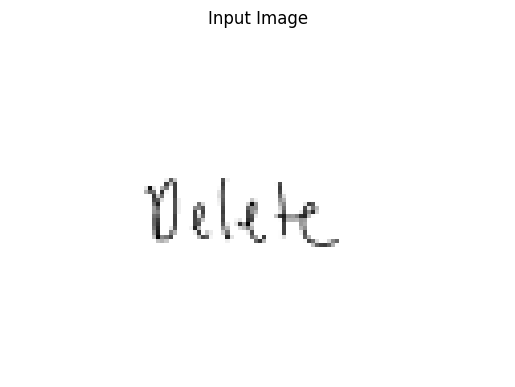

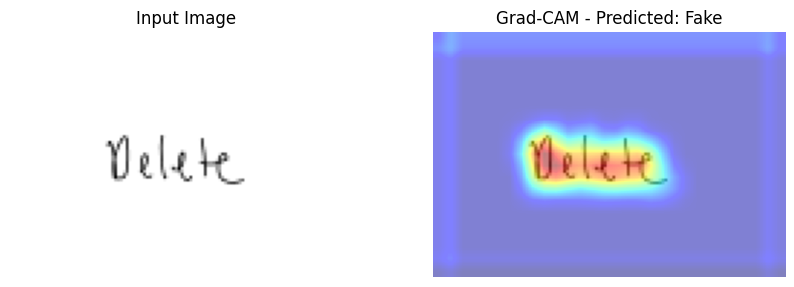

In [27]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# Image dimensions
img_h, img_w = 85, 122

# Image path
img_path = "/Users/haydenhenderson/Repos/sig_detector/Dataset/fake/page_7_sig_6_3.png"

# Define transforms for the dataset
transform = transforms.Compose([
    transforms.Resize((img_h, img_w)),  # Resize images to 85x119
    transforms.Grayscale(),             # Convert images to grayscale
    transforms.ToTensor(),              # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the pixel values to the range [-1, 1]
])

# Function to get Grad-CAM
def grad_cam(model, input_image, target_class):
    model.eval()
    
    # Get features from the last convolutional layer and the output
    def forward_hook(module, input, output):
        features.append(output)
    
    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])
    
    features = []
    gradients = []
    
    # Register hooks
    handle_forward = model.conv3.register_forward_hook(forward_hook)
    handle_backward = model.conv3.register_backward_hook(backward_hook)
    
    # Forward pass
    output, _ = model(input_image)
    
    # Zero grads
    model.zero_grad()
    
    # Backward pass for the target class
    target = output[0][target_class]
    target.backward()
    
    # Remove hooks
    handle_forward.remove()
    handle_backward.remove()
    
    # Get the gradients and features
    gradients = gradients[0].cpu().data.numpy()
    features = features[0].cpu().data.numpy()
    
    # Global average pooling of the gradients
    weights = np.mean(gradients, axis=(2, 3))[0, :]
    
    # Compute the Grad-CAM
    cam = np.zeros(features.shape[2:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * features[0, i, :, :]
    
    # Apply ReLU
    cam = np.maximum(cam, 0)
    
    # Normalize the heatmap
    cam = cam - np.min(cam)
    if  np.max(cam) != 0:
        cam = cam / np.max(cam)
 
    
    return cam

# Function to visualize Grad-CAM
def visualize_cam(image_path, model):
    image = Image.open(image_path).convert('L')
    plt.imshow(image, cmap='gray')
    plt.title("Input Image")
    plt.axis('off')
    plt.show()

    # Apply transformations
    image_tensor = transform(image).unsqueeze(0)

    # Get prediction
    output, _ = model(image_tensor)
    _, predicted_class = torch.max(output, 1)
    
    # Get Grad-CAM
    cam = grad_cam(model, image_tensor, predicted_class.item())
    
    # Visualize the Grad-CAM
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_tensor.squeeze().cpu().numpy(), cmap='gray')
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    cam = cv2.resize(cam, (img_w, img_h))
    plt.imshow(image_tensor.squeeze().cpu().numpy(), cmap='gray')
    plt.imshow(cam, cmap='jet', alpha=0.5)  # Overlay CAM
    plt.title(f"Grad-CAM - Predicted: {'Real' if predicted_class.item() == 1 else 'Fake'}")
    plt.axis('off')
    plt.show()

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 10 * 15, 512)
        self.fc2 = nn.Linear(512, 2)  # 2 output classes: fake and real

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        features = x
        x = x.view(-1, 128 * 10 * 15)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x, features

# Load the pre-trained model
model = CNN()
model.load_state_dict(torch.load('model_epoch_5.pth'))

# Visualize Grad-CAM for an example image
visualize_cam(img_path, model)
